In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures


import requests
from bs4 import BeautifulSoup


In [2]:
min_year = 1920
max_year = 2008
degr = 3
username = "spicymcspice"

In [3]:
df = pd.read_csv("watched.csv")

In [4]:
# five number summary of df[Year]
print(df["Year"].describe())

count    1360.000000
mean     1998.786765
std        21.750850
min      1920.000000
25%      1987.000000
50%      2006.000000
75%      2015.000000
max      2024.000000
Name: Year, dtype: float64


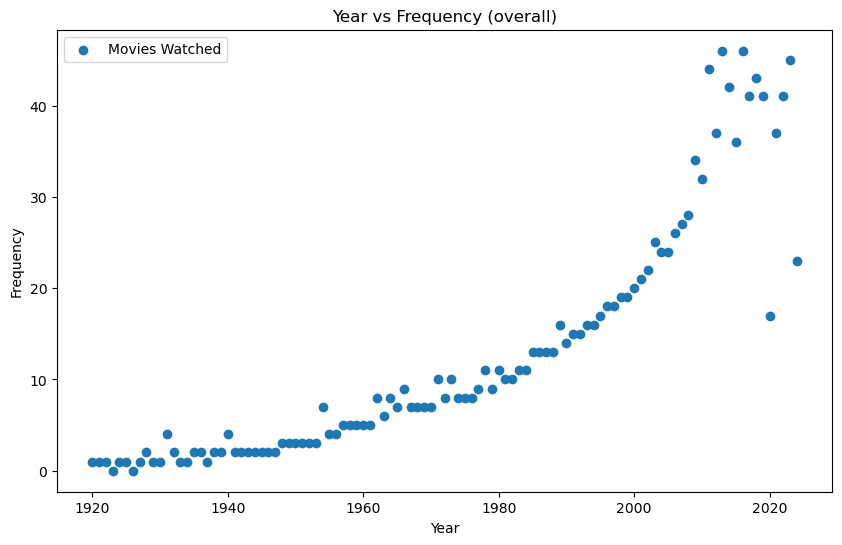

In [5]:
year_frequency = df['Year'].value_counts().reset_index()
year_frequency.columns = ['Year', 'Frequency']

missing_years = [{'Year': i, 'Frequency': 0} for i in range(min_year, max_year) if i not in year_frequency['Year'].values]
missing_years_df = pd.DataFrame(missing_years)
year_frequency = pd.concat([year_frequency, missing_years_df]).sort_values('Year').reset_index(drop=True)



# create the frequency plot
plt.figure(figsize=(10, 6))
plt.scatter(year_frequency['Year'], year_frequency['Frequency'], label='Movies Watched')
plt.title('Year vs Frequency (overall)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [6]:
# chop the frequency distribution to match the min and max years
year_frequency = year_frequency[(year_frequency['Year'] >= min_year) & (year_frequency['Year'] <= max_year)]
X = year_frequency['Year'].values.reshape(-1, 1)
y = year_frequency['Frequency'].values

print(year_frequency)



poly = PolynomialFeatures(degree=degr)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)
regression_line = model.predict(X_poly)
regression_line = np.where(regression_line <= 1, 1, regression_line)

    Year  Frequency
0   1920          1
1   1921          1
2   1922          1
3   1923          0
4   1924          1
..   ...        ...
84  2004         24
85  2005         24
86  2006         26
87  2007         27
88  2008         28

[89 rows x 2 columns]


In [7]:
predictions = regression_line
results_df = year_frequency.copy()
results_df['Exponential_Predictions'] = predictions
results_df['Residuals'] = results_df['Frequency'] - results_df['Exponential_Predictions']

results_df.head()

,Year,Frequency,Exponential_Predictions,Residuals
0,1920,1,1.0,0.0
1,1921,1,1.0,0.0
2,1922,1,1.0,0.0
3,1923,0,1.0,-1.0
4,1924,1,1.0,0.0


In [8]:
equation = f'y = {model.intercept_:.4f}'
for i, coef in enumerate(model.coef_):
    equation += f' + {coef:.6f}x^{i+1}'
print(equation)

y = -350920.6741 + 0.000000x^1 + 543.377522x^2 + -0.280512x^3 + 0.000048x^4


In [9]:
results_df.to_csv('polyreg.csv', index=False)

print("Exported the exponential regression results to 'polyreg.csv'")

Exported the exponential regression results to 'polyreg.csv'


In [10]:
print(results_df.sort_values(by='Residuals').head(16))

    Year  Frequency  Exponential_Predictions  Residuals
27  1947          2                 3.223839  -1.223839
62  1982         10                11.203520  -1.203520
17  1937          1                 2.156480  -1.156480
26  1946          2                 3.108495  -1.108495
79  1999         19                20.107446  -1.107446
59  1979          9                10.066208  -1.066208
56  1976          8                 9.039099  -1.039099
64  1984         11                12.026814  -1.026814
74  1994         16                17.011224  -1.011224
6   1926          0                 1.000000  -1.000000
3   1923          0                 1.000000  -1.000000
25  1945          2                 2.995836  -0.995836
33  1953          3                 3.988522  -0.988522
72  1992         15                15.890892  -0.890892
24  1944          2                 2.885573  -0.885573
32  1952          3                 3.850982  -0.850982


In [11]:
print('Mean Squared Error:', mean_squared_error(results_df['Frequency'], results_df['Exponential_Predictions']))
print('Mean Absolute Error:', mean_absolute_error(results_df['Frequency'], results_df['Exponential_Predictions']))

Mean Squared Error: 0.979414901258143
Mean Absolute Error: 0.7525734594811193


In [12]:
min_resid_yr = results_df.loc[results_df['Residuals'].idxmin(), 'Year']
print(f"The year with the lowest negative residual is {min_resid_yr}")
url = f'https://letterboxd.com/{username}/watchlist/year/{min_resid_yr}/by/popular/'


The year with the lowest negative residual is 1947


In [13]:

# response = requests.get(url)

# if response.status_code == 200:
#     soup = BeautifulSoup(response.text, 'html.parser')
#     # print(soup.prettify())
#     ul_el = soup.find('ul', class_='poster-list')
#     first_movie = ul_el.find('li')
#     img = first_movie.find('img')
#     img_tag = img['alt']
#     print(f"The most popular movie in {min_resid_yr} from your watchlist is {img_tag}")



Number of rounds to reach only increasing: 162


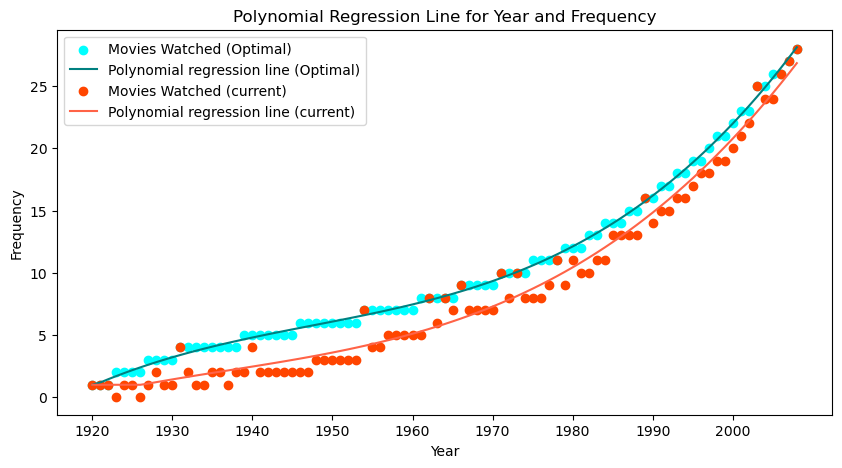

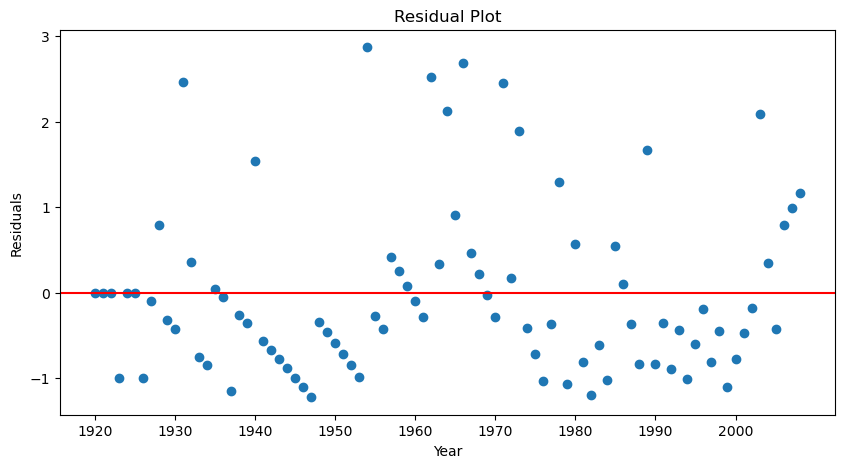

In [14]:
old_regression_line = regression_line
num_rounds = 0
freq_copy = results_df.copy()
only_increasing = False

while only_increasing == False:
    new_min_resid_yr = freq_copy.loc[freq_copy['Residuals'].idxmin(), 'Year']
    num_rounds += 1
    freq_copy.loc[freq_copy['Year'] == new_min_resid_yr, 'Frequency'] += 1

    X = freq_copy['Year'].values.reshape(-1, 1)
    y = freq_copy['Frequency'].values
    poly = PolynomialFeatures(degree=degr)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    new_regression_line = model.predict(X_poly)
    new_regression_line = np.where(new_regression_line <= 1, 1, new_regression_line)
    freq_copy['Exponential_Predictions'] = new_regression_line
    freq_copy['Residuals'] = freq_copy['Frequency'] - freq_copy['Exponential_Predictions']
    # runs through the frequency column to check if it is only increasing
    only_increasing = all(freq_copy['Frequency'].iloc[i] <= freq_copy['Frequency'].iloc[i+1] for i in range(len(freq_copy)-1))

print(f"Number of rounds to reach only increasing: {num_rounds}")


plt.figure(figsize=(10, 5))
plt.scatter(freq_copy['Year'], freq_copy['Frequency'], label='Movies Watched (Optimal)', color='aqua')
plt.plot(freq_copy['Year'], new_regression_line, color='teal', label='Polynomial regression line (Optimal)')
plt.scatter(year_frequency['Year'], year_frequency['Frequency'], label='Movies Watched (current)', color='orangered')
plt.plot(year_frequency['Year'], old_regression_line, color='tomato', label='Polynomial regression line (current)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Polynomial Regression Line for Year and Frequency')
plt.legend()
plt.xticks(np.arange(min_year, max_year+1, 10))
plt.show()

# residual plot
plt.figure(figsize=(10, 5))
plt.scatter(results_df['Year'], results_df['Residuals'])
plt.axhline(y=0, color='red')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.xticks(np.arange(min_year, max_year+1, 10))
plt.show()
